<a href="https://colab.research.google.com/github/bubriks/ID2223/blob/main/Project/project-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Course Project: Scalable Machine Learning and Deep Learning**

## **Paolo Teta & Ralfs Zangis**
---

# **Requirements**

**Spark**

In [93]:
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder.getOrCreate()

**Tensorflow**

In [94]:
import tensorflow as tf

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

**Other**

In [95]:
import numpy as np
import matplotlib.pyplot as plt

**Mount Google Drive**

In [96]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
# **1. Get the data**

**Link:** https://drive.google.com/file/d/1Du-gZz1LU-StWbahzckG1EmSLC-FuW5S/view?usp=sharing

In [98]:
schema = StructType([
    StructField("emotion", IntegerType(), True),
    StructField("pixels", StringType(), True),
    StructField("Usage", StringType(), True)])

data = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/dataset-project.csv", header=True, schema=schema)
data = data.withColumn("id", monotonically_increasing_id())
data = data.withColumn("pixels", split(col("pixels"), " ").cast("array<int>"))

Py4JError: ignored

---
# **2. Explore the data**

In [99]:
data.printSchema()
print((data.count(), len(data.columns)))

Py4JError: ignored

In [100]:
data.show(5)

StructType(StructField(emotion,IntegerType,true), StructField(pixels,ArrayType(ArrayType(FloatType,true),true),true), StructField(Usage,StringType,true), StructField(id,LongType,false))


In [101]:
data.select("Usage").distinct().collect()

Py4JError: ignored

In [102]:
data.groupBy(col("emotion")).count().sort(asc("emotion")).show()

KeyError: ignored

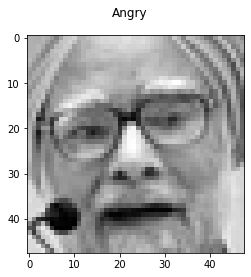

In [63]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

dataId = 1

row = data.filter(col("id") == dataId).first()
plt.figure(dataId)
pixelArray = np.asarray(row["pixels"])
plt.suptitle(emotion_labels[row["emotion"]])
plt.imshow(pixelArray.reshape((48, 48)), interpolation='none', cmap='gray')

---
# **3. Prediction**

Normalize pixels

In [64]:
normalizeUdf = udf(lambda pixelArray: [pixel/255 for pixel in pixelArray],
                   ArrayType(FloatType()))

data = data.withColumn("pixels", normalizeUdf(col("pixels")))

Reshape pixels

In [68]:
reshapeUdf = udf(lambda pixelArray: np.array(pixelArray).reshape((48, 48)).tolist(),
                 ArrayType(ArrayType(FloatType())))

data = data.withColumn("pixels", reshapeUdf(col("pixels")))

+-------+--------------------+--------+---+
|emotion|              pixels|   Usage| id|
+-------+--------------------+--------+---+
|      0|[[0.27450982, 0.3...|Training|  0|
|      0|[[0.5921569, 0.58...|Training|  1|
|      2|[[0.90588236, 0.8...|Training|  2|
|      4|[[0.09411765, 0.1...|Training|  3|
|      6|[[0.015686275, 0....|Training|  4|
+-------+--------------------+--------+---+
only showing top 5 rows



Separate dataset

In [69]:
train_set = data.filter(col("Usage") == "Training").select("emotion", "pixels")
val_set = data.filter(col("Usage") == "PublicTest").select("emotion", "pixels")
test_set = data.filter(col("Usage") == "PrivateTest").select("emotion", "pixels")

In [77]:
train_set.show()
train_set.select("pixels").collect()

KeyError: ignored

In [51]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.0,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  

datagen.fit(train_set)

Py4JJavaError: ignored

In [ ]:
%matplotlib notebook

import cv2
import matplotlib.pyplot as plt
import signal

In [ ]:
def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

In [ ]:
vc = cv2.VideoCapture(0)

plt.ion()

if vc.isOpened(): # try to get the first frame
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview = plt.imshow(frame)    
else:
    is_capturing = False

signal.signal(signal.SIGINT, signal_handler)
is_interrupted = False
while is_capturing:
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview.set_data(frame)
    plt.draw()

    try:    # Avoids a NotImplementedError caused by `plt.pause`
        plt.pause(0.05)
    except Exception:
        pass
    if is_interrupted:
        vc.release()
        break